## 2 Neural Machine Translation

> a) Implement the below model

> b) Use a small set of real machine translation data

> c) Test with some (very similar) sentences

 




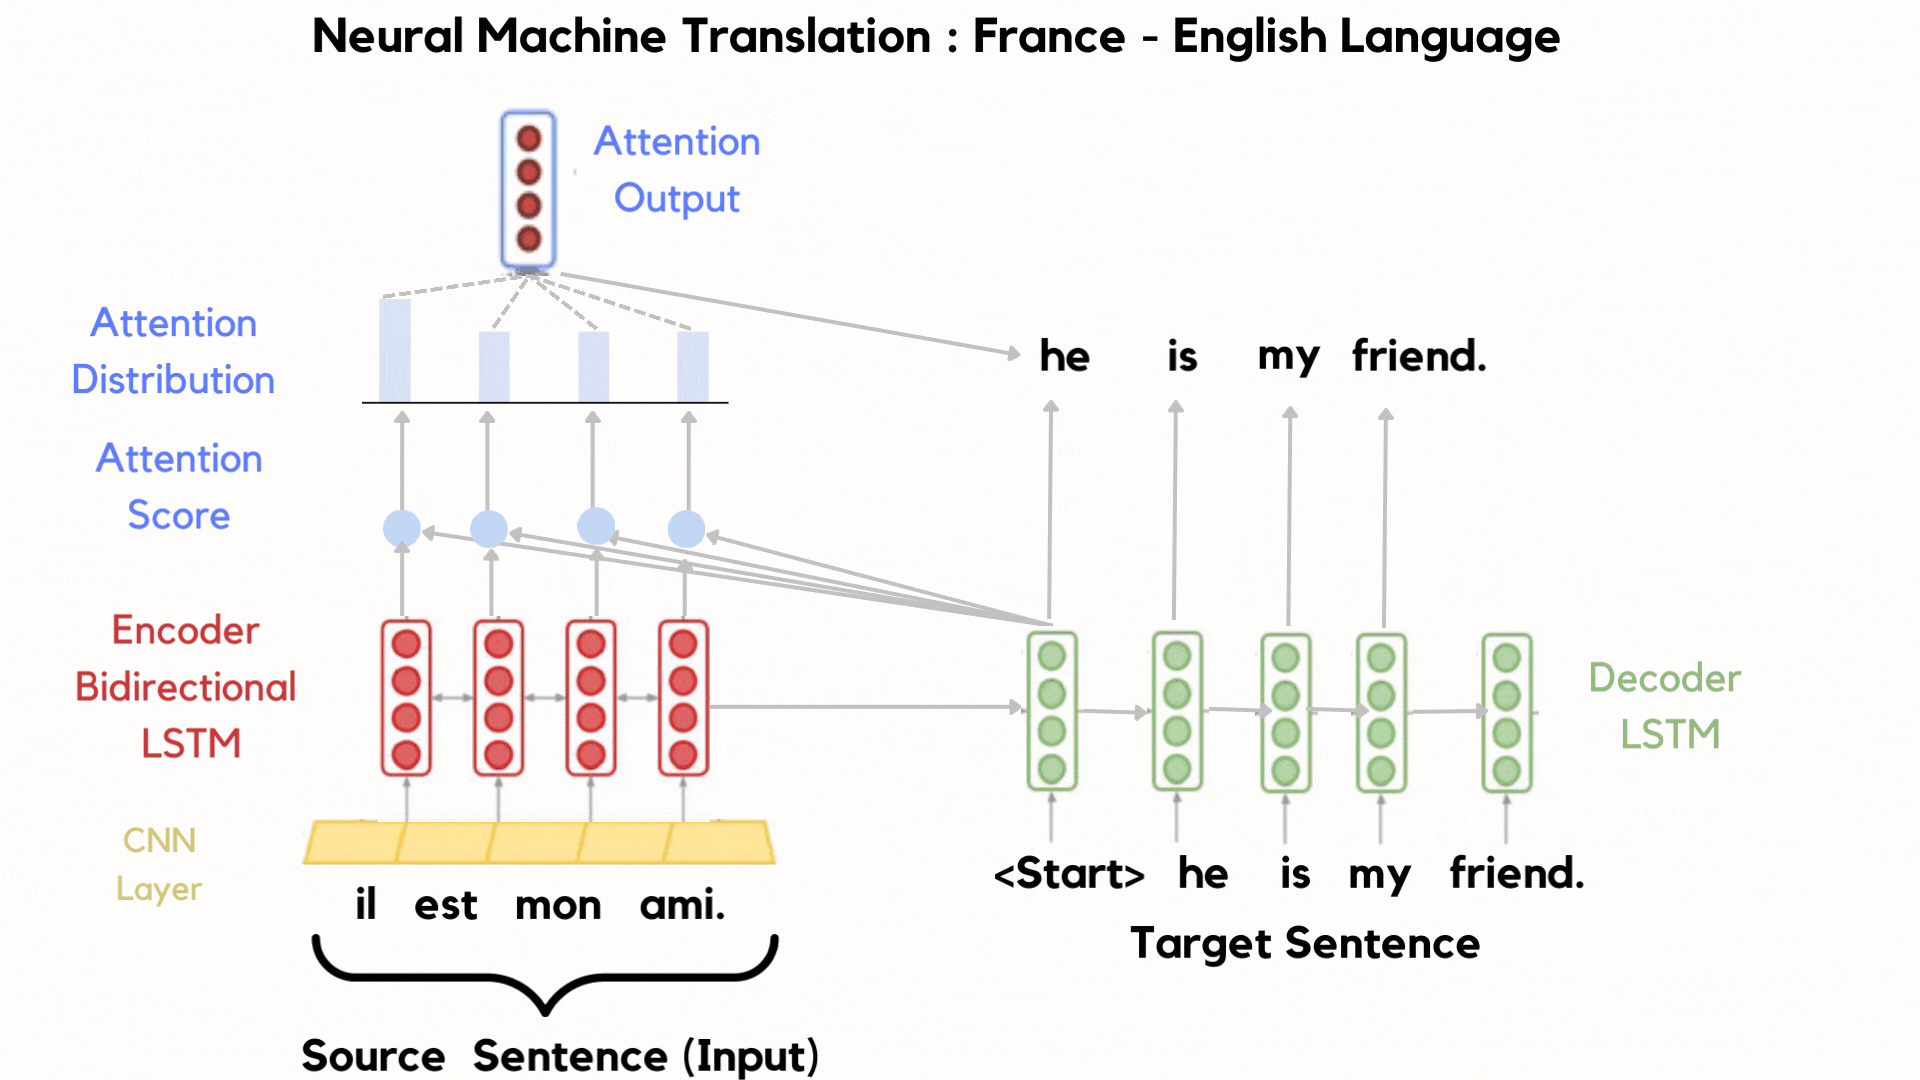

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
# Download the file
path_to_file = tf.keras.utils.get_file(
    'fra-eng.txt', origin='https://drive.google.com/uc?id=1OiKLw5gFBehmdefWlkswXSipSYHriWIS')

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿,，,。])", r" \1 ", w)
  w = re.sub(r'([\u4e00-\u9fff])', r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
# Each element is treated as a separate word
preprocess_sentence(u'Je vais bien').split(' ')

['<start>', 'je', 'vais', 'bien', '<end>']

In [ ]:
en_sentence = u"You look very good."
fra_sentence = u"Tu as l'air très bien."
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(fra_sentence))

<start> you look very good . <end>
<start> tu as l'air tres bien . <end>


In [ ]:
# Return word pairs in the format: [ENGLISH, FRANCE]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  samples = lines[:num_examples]
  
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')][:2]  for l in samples]
  return zip(*word_pairs)

en, fra = create_dataset(path_to_file, None)
print(en[-1])
print(fra[-1])

<start> it may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> il est peut-etre impossible d'obtenir un corpus completement denue de fautes , etant donnee la nature de ce type d'entreprise collaborative . cependant , si nous encourageons les membres a produire des phrases dans leurs propres langues plutot que d'experimenter dans les langues qu'ils apprennent , nous pourrions etre en mesure de reduire les erreurs . <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 35000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

28000 28000 7000 7000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print(input_tensor_train[0])
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

[   1   18   20 8676    3    2    0    0    0    0    0    0    0    0
    0    0    0    0]
Input Language; index to word mapping
1 ----> <start>
18 ----> c'est
20 ----> un
8676 ----> negre
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
57 ----> he's
7 ----> a
4183 ----> ghostwriter
3 ----> .
2 ----> <end>


In [ ]:
# Create tf.data dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 18]), TensorShape([32, 11]))

In [ ]:
BUFFER_SIZE

28000

In [ ]:
steps_per_epoch

875

# **Encoder and decoder model**

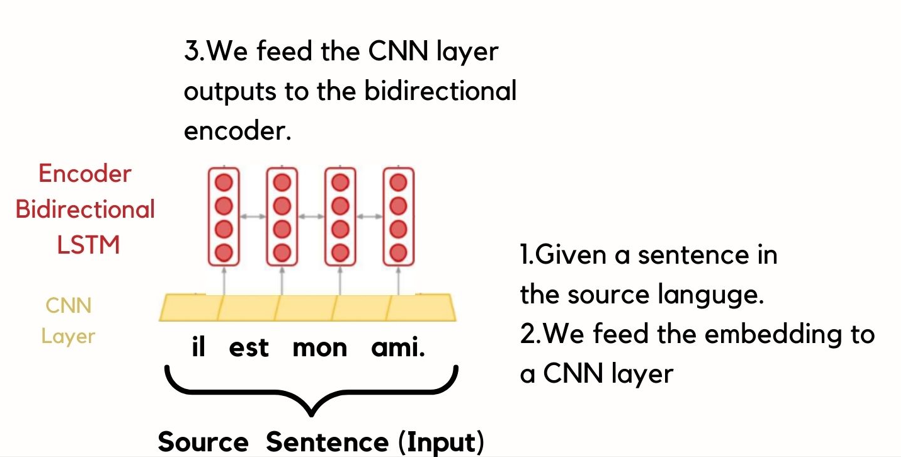

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.cnn = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        recurrent_initializer='glorot_uniform'))

    def call(self, x, hidden):
        x = self.embedding(x)
        x = self.cnn(x)
        output, forward_h, forward_c, backward_h, backward_c = self.lstm(x, initial_state = hidden)
        state_h = tf.concat([forward_h, backward_h], axis=-1)
        state_c = tf.concat([forward_c, backward_c], axis=-1)
        return output, [state_h, state_c]

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)) for _ in range(4)]


encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', [hidden.shape for hidden in sample_hidden])

Encoder output shape: (batch size, sequence length, units) (32, 18, 1024)
Encoder Hidden state shape: (batch size, units) [TensorShape([32, 1024]), TensorShape([32, 1024])]


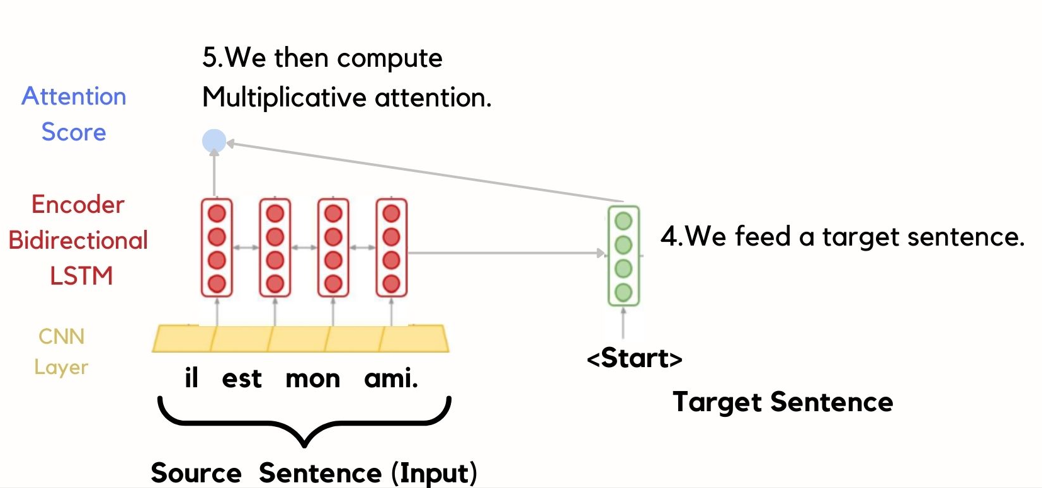

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()

  def call(self, query, values):

    query_with_time_axis = tf.expand_dims(query, 1)

    score = tf.reduce_sum(query_with_time_axis * values, axis=2)

    attention_weights = tf.nn.softmax(score, axis=1)

    attention_weights_expanded = tf.expand_dims(attention_weights, 2)
    context_vector = attention_weights_expanded * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = LuongAttention(units)
attention_result, attention_weights = attention_layer(sample_hidden[0], sample_output)


print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 18)


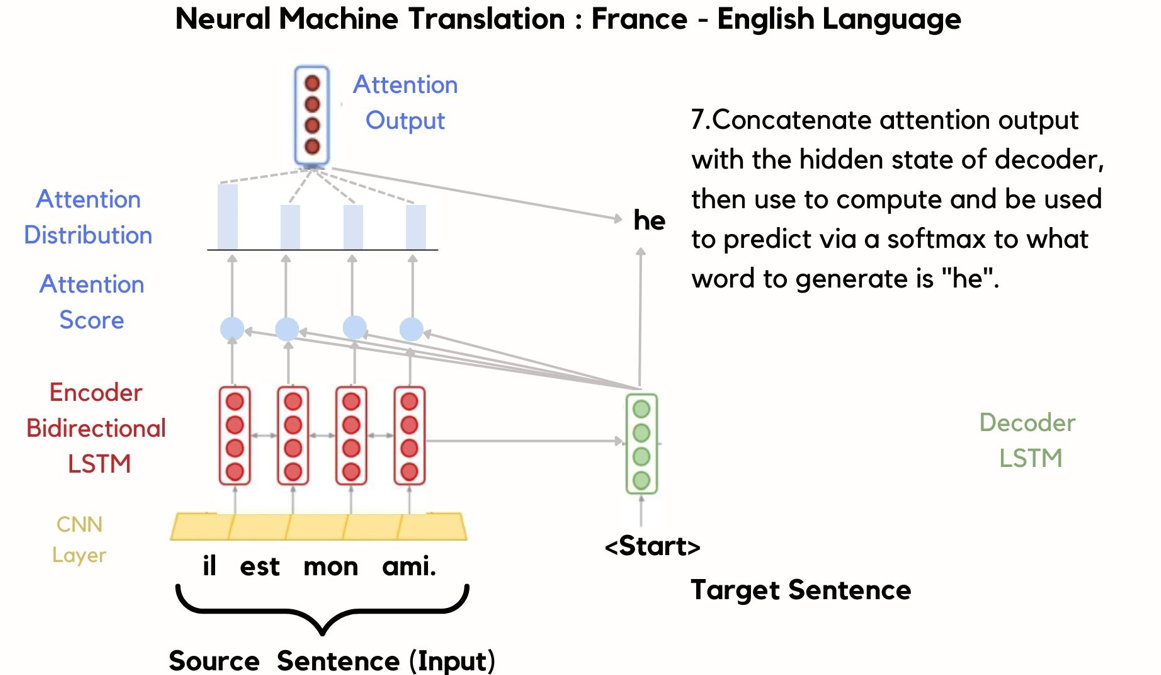

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(2*self.dec_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = LuongAttention(self.dec_units)

    def call(self, x, hidden, enc_output, training=False, mask=None):
        # hidden state is a list: [hidden_state, cell_state]
        hidden_state = hidden[0]
        cell_state = hidden[1]
        hidden = [hidden_state, cell_state]

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x, initial_state=hidden)  # LSTM returns output and two state tensors

        # Using Attention Layer
        attention_result, attention_weights = self.attention(state_h, enc_output)

        # Expand dimensions of attention_result
        attention_result = tf.expand_dims(attention_result, 1)

        # Concat attention output and decoder LSTM output 
        decoder_concat_input = tf.concat([output, attention_result], axis=-1)

        # output shape == (batch_size * 1, hidden_size)
        decoder_concat_input = tf.reshape(decoder_concat_input, (-1, decoder_concat_input.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(decoder_concat_input)

        return x, [state_h, state_c], attention_weights  # LSTM returns two states


decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 4983)


# Loss function


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
# checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Training


In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.3538
Epoch 1 Batch 100 Loss 2.2175
Epoch 1 Batch 200 Loss 1.9343
Epoch 1 Batch 300 Loss 1.7988
Epoch 1 Batch 400 Loss 1.3893
Epoch 1 Batch 500 Loss 1.6410
Epoch 1 Batch 600 Loss 1.5208
Epoch 1 Batch 700 Loss 1.5196
Epoch 1 Batch 800 Loss 1.3406
Epoch 1 Loss 1.6887
Time taken for 1 epoch 66.10212850570679 sec

Epoch 2 Batch 0 Loss 1.0903
Epoch 2 Batch 100 Loss 1.2042
Epoch 2 Batch 200 Loss 1.1958
Epoch 2 Batch 300 Loss 1.1499
Epoch 2 Batch 400 Loss 1.0686
Epoch 2 Batch 500 Loss 1.1451
Epoch 2 Batch 600 Loss 1.0088
Epoch 2 Batch 700 Loss 1.0489
Epoch 2 Batch 800 Loss 0.9403
Epoch 2 Loss 1.1101
Time taken for 1 epoch 39.30686831474304 sec

Epoch 3 Batch 0 Loss 0.7698
Epoch 3 Batch 100 Loss 0.9391
Epoch 3 Batch 200 Loss 0.7873
Epoch 3 Batch 300 Loss 0.8966
Epoch 3 Batch 400 Loss 0.8138
Epoch 3 Batch 500 Loss 0.8625
Epoch 3 Batch 600 Loss 0.7359
Epoch 3 Batch 700 Loss 0.7214
Epoch 3 Batch 800 Loss 0.7984
Epoch 3 Loss 0.7972
Time taken for 1 epoch 38.561598777770996 se

In [ ]:
def evaluate(sentence):

    sentence = preprocess_sentence(sentence)
    print(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''


    hidden = [tf.zeros((1, units)) for _ in range(4)]
    enc_out, enc_hidden = encoder(inputs, hidden)
    

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, #attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, #attention_plot


In [ ]:
def translate(sentence):
  result, sentence = evaluate(sentence)
  print('Input in France: %s' % (sentence))
  print('Predicted translation in English: {}'.format(result))

In [ ]:
translate(u'Merci beaucoup.')

<start> merci beaucoup . <end>
Input in France: <start> merci beaucoup . <end>
Predicted translation in English: thank you very much . <end> 


In [ ]:
translate(u'je suis desole.')

<start> je suis desole . <end>
Input in France: <start> je suis desole . <end>
Predicted translation in English: i'm sorry . <end> 


In [ ]:
translate(u'Je ne comprends pas.')

<start> je ne comprends pas . <end>
Input in France: <start> je ne comprends pas . <end>
Predicted translation in English: i don't understand . <end> 
